<center>
<h4>Universidad Nacional de Córdoba - Facultad de Matemática, Astronomía, Física y Computación</h4>
<h3>Diplomatura en Ciencia de Datos, Aprendizaje Automático y sus Aplicaciones</h3>
</center>


<h1> Análisis y Visualización de Datos - 2019 </h1>
<h2>Logística de envío: ¿Cuando llega?</h2>


<h4>Introducción</h4>

Uno de los aspectos cruciales vinculado a la comercialización de productos mediante plataformas online se encuentra relacionado al tiempo que transcurre entre el momento en que el usuario o el cliente efectiviza un pedido y el momento en que le es entregado.

Como una primera aproximación a esta problemática se trabajará con datos de envíos de MercadoLibre, el e-commerce más grande de Latinoamérica, empleando técnicas exploratorias y descriptivas de índole estadísticas para poder responder: ¿cuándo llega?.

<h4> Datos y caracterización inicial</h4>

Los datos disponibles corresponden a un muestreo aleatorio no uniforme de 500.000 envíos de MercadoLibre. Estos envíos fueron realizados en Brasil en el período comprendido entre octubre de 2018 y abril de 2019. Si bien las fechas disponibles no son las reales a efectos de propiciar la confidencialidad de las transacciones, conservan el día de la semana considerando incluso la presencia de los feriados correspondientes. Los datos comprenden variables tanto categóricas como numéricas.

Entre las variables disponibles se disponen de dos cuantitativas de relevancia para los propósitos de este análisis:
- *Shipment_days*: Días hábiles entre que el envío fue enviado (salió del correo) y que fue entregado.
- *Quantity*: Cantidad de productos en un envío.

Adicionalmente, se disponen de fechas claves de cada transacción:
 - *Date_created*: Fecha de creación del envío.
 - *Date_sent*: Fecha y hora en que se realizó el envío (salió del correo).
 - *Date_visit*: Fecha y hora en que se entregó el envío al destinatario. 

Se cuenta también con variables categóricas referidas a:
- Aspectos geográficos de las transacciones:
 - *Sender_state*: Estado de Brasil de donde sale el envío.
 - *Sender_zipcode*: Código postal (de 5 dígitos) de donde sale el envío.
 - *Receiver_state*: Estado de Brasil a donde llega el envío.
 - *Receiver_zipcode*: Código postal (de 5 dígitos) a donde llega el envío.
 
- Características de los envíos:
 - *Shipment_type*: Método de envío (*normal, express, super*).
 - *Service*: Servicio del correo con el cual se realizó un envío.
 - *Status*: Estado del envío (*set*: listo para ser enviado, *sent*: enviado, *done*: entregado, *failed*: no entregado, *cancelled*: cancelado).

In [6]:
import matplotlib.pyplot as plt
import numpy
import pandas
import seaborn
from scipy import stats
import itertools
#from google.colab import files
import io
from IPython.display import HTML

BLUE = '#35A7FF'
RED = '#FF5964'
GREEN = '#6BF178'
YELLOW = '#FFE74C'

In [0]:
# Ocultar código

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

In [0]:
seaborn.__version__

'0.9.0'

In [13]:
import sys
in_colab = 'google.colab' in sys.modules

if in_colab:
  BASE_DIR = "https://github.com/cnoeliachaves/diplodatos/raw/master/"
else:
  BASE_DIR = "."

In [14]:
#url = "https://raw.githubusercontent.com/cnoeliachaves/practico2Analisis/master/dataset_sample_corrected.csv?token=ADKWG6EBNM7S5O6PVV5RII244K572"
#uploaded = files.upload()
#dataset = pandas.read_csv(io.BytesIO(uploaded['dataset_sample_corrected.csv']))
dataset = pandas.read_csv(BASE_DIR + "/dataset_sample_corrected.csv")
dataset.shape

(500000, 12)

In [0]:
dataset.columns


Index(['sender_state', 'sender_zipcode', 'receiver_state', 'receiver_zipcode',
       'shipment_type', 'quantity', 'service', 'status', 'date_created',
       'date_sent', 'date_visit', 'shipment_days'],
      dtype='object')

A continuación se presenta una pequeña muestra de la base de datos mencionada, así como un análisis descriptivo exploratorio a efectos de indagar los datos provistos. 

In [0]:
dataset[dataset.columns].sample(10)

,sender_state,sender_zipcode,receiver_state,receiver_zipcode,shipment_type,quantity,service,status,date_created,date_sent,date_visit,shipment_days
309085,SP,8090,SP,3318,express,1,0,done,2019-03-26 00:00:00,2019-03-27 16:29:00,2019-03-28 14:09:00,1.0
311353,SP,6850,BA,44009,standard,2,2,done,2019-03-05 00:00:00,2019-03-07 16:39:58,2019-03-25 10:27:00,12.0
74378,SP,2995,RS,90230,standard,1,1,done,2019-02-09 00:00:00,2019-02-13 16:05:00,2019-02-28 10:40:00,11.0
482084,SP,3106,GO,76160,standard,2,2,done,2019-03-22 00:00:00,2019-03-22 22:47:40,2019-03-28 08:06:00,4.0
250323,SP,4660,RS,96015,standard,1,1,done,2019-03-05 00:00:00,2019-03-06 12:02:00,2019-03-27 10:57:00,14.0
120230,SP,9571,SP,13051,express,1,0,done,2019-03-04 00:00:00,2019-03-05 15:21:00,2019-03-11 13:19:00,2.0
332213,SP,8223,MG,36200,standard,1,1,done,2019-02-28 00:00:00,2019-02-28 17:29:00,2019-03-15 11:06:00,8.0
33305,SP,13290,RS,96213,express,1,6,done,2019-03-02 00:00:00,2019-03-04 05:28:04,2019-03-11 08:25:05,2.0
251112,SP,5034,PE,52020,standard,1,2,done,2019-03-09 00:00:00,2019-03-12 17:00:28,2019-03-21 05:24:00,7.0
71947,SP,1510,RS,91350,express,1,0,done,2019-03-22 00:00:00,2019-03-25 16:34:00,2019-03-26 14:54:00,1.0


Como se puede apreciar en la tabla siguiente, los datos de los envíos analizados corresponden a aquellos que se realizan solamente desde el estado de Sao Paulo. En tanto, los envíos tienen como destinos a la totalidad de unidades federales en que se dividide Brasil (27): 26 estados más el Distrito Federal.
Por su parte, 494.983 de los 500.000 envíos registrados (casi el 99 %) fueron entregados (*status = done*).

In [0]:
dataset.describe(include='all').transpose()

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
sender_state,500000,1,SP,500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sender_zipcode,500000,NaN,NaN,NaN,8305.33,5088.26,1001,3673,7274,13277,19970
receiver_state,500000,27,SP,190586,NaN,NaN,NaN,NaN,NaN,NaN,NaN
receiver_zipcode,500000,NaN,NaN,NaN,39982.6,30975,1001,13140,31150,70670,99990
shipment_type,500000,3,standard,263227,NaN,NaN,NaN,NaN,NaN,NaN,NaN
quantity,500000,NaN,NaN,NaN,1.27819,0.661639,1,1,1,1,5
service,500000,NaN,NaN,NaN,1.51571,1.82631,0,0,1,2,12
status,500000,5,done,494983,NaN,NaN,NaN,NaN,NaN,NaN,NaN
date_created,500000,150,2019-03-05 00:00:00,20456,NaN,NaN,NaN,NaN,NaN,NaN,NaN
date_sent,499971,81391,2019-03-11 15:53:00,113,NaN,NaN,NaN,NaN,NaN,NaN,NaN


En cuanto a las variables cuantitativas en este análisis preliminar, se aprecia que al menos el 75% de los envíos contienen un solo producto (variable *quantity*). La máxima cantidad de productos en un mismo envío es de 5. 

En relación a la variable *shipment_days*, lo primero que se destaca es la presencia de valores negativos, particularmente un valor mínimo de ***-77 días***. En el gráfico que se presenta a continuación de la tabla (*boxplot* o diagrama de caja y brazos) se destaca que existen otros valores negativos en relación a esta variable, así como *valores atípicos*: elevados en relación a la distribución en su conjunto.

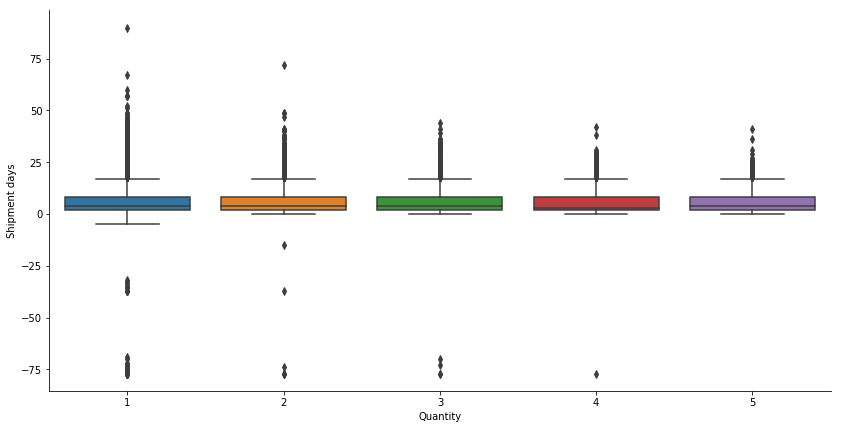

In [0]:
plt.figure(figsize=(14,7))
seaborn.boxplot(data=dataset,
                y='shipment_days', x='quantity')
plt.ylabel('Shipment days')
plt.xlabel('Quantity')
seaborn.despine()

En el gráfico de arriba podemos observar que hay muchos valores negativos, que los podemos eliminar dado que shipment_days 
cuenta la cantidad de días en que dura la entrega de un paquete.

Los valores negativos de la variables *shipment days* son 48 observaciones, correspondiendo a tipos de envíos *express* (27) y *standard* (21). 

Esas observaciones provienen de los servicios postales 2, 4, 7 y 9. A este último corresponde la mayor cantidad de registros negativos.

In [0]:
dfna = dataset[dataset.shipment_days < 0]
pandas.pivot_table(dfna, values='shipment_days', index=['shipment_type'],
                     columns=['service'], aggfunc=len)

service,2,4,7,9
shipment_type,,,,
express,NaN,5.0,1.0,21.0
standard,2.0,10.0,8.0,1.0


In [0]:
# Contamos cuantas columnas tienen valores negativos y limite_superior_outliers
dataset[dataset['shipment_days'] < 0]['shipment_days'].count()

48

In [0]:
dataset[dataset['shipment_days'] > 17]['shipment_days'].count()

14730

Dado que la fuente de datos es de índole secundaria, una manera de *corregir* estos valores erróneos es recurriendo a alguna técnica de imputación pertinente. Dado la cantidad de datos disponibles, en lo que sigue del informe dejaremos fuera de consideración este tipo de valores anómalos, así como los valores atípicos de la variable *shipment days*. Se definirá como atípicos a aquellos que superen el límite dado por la siguiente expresión:

$$LSO = Q_3 + 1,5 \cdot (Q_3 - Q_1)$$

Donde $Q_1$ y $Q_3$ corresponden a los percentiles 25 (o cuartil 1) y 75 (o cuartil 3). En tanto, la diferencia $(Q_3 - Q_1)$ se denomina recorrido o rango intercuartílico.

En este caso particular, de acuerdo a los valores dado más arriba, el límite está dado por:

$$LSO = 8 + 1,5 \cdot (8 - 2) = 17$$

Por lo que se considerarán como atípicos a aquellas observaciones con *shipment days* superiores a 17 días.

In [15]:
def clean_shipment_days(dataset):
    """Le saco los valores negativos"""
    shipments_days = dataset['shipment_days']
    mask = (shipments_days >= 0)
    mask_2 = (shipments_days < 18)
    return dataset[mask & mask_2] 

In [16]:
dataset_clean = clean_shipment_days(dataset)

In [12]:
#Contemos cuantos datos hemos eliminado
dataset_clean.count()

sender_state        484620
sender_zipcode      484620
receiver_state      484620
receiver_zipcode    484620
shipment_type       484620
quantity            484620
service             484620
status              484620
date_created        484620
date_sent           484620
date_visit          484620
shipment_days       484620
dtype: int64

Tras las consideraciones enunciadas, la base de datos se reduce a 484.620 registros de envíos, por lo que se pierden apenas el 3% de las observaciones. Esto nos permite respaldar la decisión de no considerar estos valores en lo que sigue del informe.

Tomando en cuenta este nuevo conjunto de datos, medidas estadísticas descriptivas como la media se tornan más represenativas, dado que no se ven influenciadas por los valores atípicos y negativos. Particularmente, vemos que la media de cantidades de productos (*quantity*) de los envíos es de 1,28 unidades. 

En promedio los envíos demoran 4,89 días, en relación a la variable *shipment days*. En este último caso, podemos notar que la mediana (percentil 50) resulta inferior a la media. Esto es una señal de la existencia de asimetría derecha en la distribución de la variable *shipment days*, aspecto sobre el que volveremos más adelante.

In [0]:
#Calculamos la descripci´n estadísticas sobre las variables cuantitativas. 
descrip = dataset_clean[['quantity', 'shipment_days']].describe().round(2).transpose()
descrip['CV'] = (descrip['std']/descrip['mean']*100).round(2)
descrip

,count,mean,std,min,25%,50%,75%,max,CV
quantity,484620.0,1.28,0.66,1.0,1.0,1.0,1.0,5.0,51.56
shipment_days,484620.0,4.89,4.14,0.0,2.0,3.0,7.0,17.0,84.66


De acuerdo a la información de la tabla anterior se aprecia que *shipment days* tiene una mayor dispersión relativa que *quantity*, lo cual se refleja en su mayor coeficiente de variación (cv): los datos de *shipment days* se desvían de su media en un 84,6% en promedio. 

En *quantity* existe una importante concentración en un producto (80,6%), mientras que solo el 5,6% de los envíos tienen tres o más productos (ver tabla siguiente). 

In [0]:
quantity_tab = pandas.crosstab(index = dataset_clean["quantity"],
                              columns="count") 
quantity_tab['percentage'] = (quantity_tab['count']/quantity_tab['count'].sum()*100).round(2)
quantity_tab

col_0,count,percentage
quantity,,
1,390746,80.63
2,66874,13.80
3,15349,3.17
4,9250,1.91
5,2401,0.50


En relación al método de envío (*shipment type*), existen diferencias importantes en el promedio de *shipment days* en las tres categorías o tipos. 

Un aspecto a destacar es el caso del método *express*, que es el de mayor dispersión o variabilidad relativa (cv), por lo que su media es menos representativa que las de los tipos *super* y *standard*.

In [0]:
descrip_days_st = dataset_clean.groupby('shipment_type')['shipment_days'].describe().round(2)
descrip_days_st['cv'] = (descrip_days_st['std']/descrip_days_st['mean']*100).round(2)
descrip_days_st

,count,mean,std,min,25%,50%,75%,max,cv
shipment_type,,,,,,,,,
express,226123.0,2.14,1.70,0.0,1.0,2.0,3.0,17.0,79.44
standard,248240.0,7.56,4.03,0.0,4.0,7.0,10.0,17.0,53.31
super,10257.0,1.08,0.61,0.0,1.0,1.0,1.0,11.0,56.48


Mediante un análisis análogo al del párrafo anterior, se puede observar que no exiten diferencias siginificativas en la variable *quantity* entre los distintos tipos de envíos.

In [0]:
descrip_q_st = dataset_clean.groupby('shipment_type')['quantity'].describe().round(2)
descrip_q_st['cv'] = (descrip_q_st['std']/descrip_q_st['mean']*100).round(2)
descrip_q_st

,count,mean,std,min,25%,50%,75%,max,cv
shipment_type,,,,,,,,,
express,226123.0,1.28,0.66,1.0,1.0,1.0,1.0,5.0,51.56
standard,248240.0,1.28,0.66,1.0,1.0,1.0,1.0,5.0,51.56
super,10257.0,1.28,0.67,1.0,1.0,1.0,1.0,5.0,52.34


In [0]:
dataset['date_visit'].unique()

array(['2019-03-18 09:52:00', '2019-03-18 15:16:00',
       '2019-03-01 21:27:00', ..., '2019-03-27 17:05:36',
       '2019-03-07 16:34:06', '2019-03-13 13:28:17'], dtype=object)

In [0]:
dataset['status'].unique()

array(['done', 'failed', 'sent', 'cancelled', 'set'], dtype=object)

In [0]:
dataset['shipment_type'].unique()

array(['standard', 'express', 'super'], dtype=object)

In [0]:
dataset['service'].unique()

array([ 1,  2,  9,  0,  4,  6,  3,  5,  8,  7, 10, 12, 11])

In [0]:
dataset['sender_state'].unique()

array(['SP'], dtype=object)

In [0]:
len(dataset['sender_zipcode'].unique())

5452

 Estadísticos descriptivos

1. Sender_zipcode su rango esta dentro de 1000 y 20000. Es una variable categórica, que indifica las zonas geográficas desde donde se realizaron los envíos. 
2. receiver_zipcode su rango esta dentro de 1000 y 100000. Es una variable categórica.
3. Quantity va desde 1 hasta 5
4. Service va desde 0  hasta 12
5. shipment_days va desde -77 hasta 90. Pero nos quedamos con los valores entre [0,18]

##  Distribución de la variable *shipment days*

Con el propósito de realizar futuros análisis, es importante indagar sobre la forma de la distribución de la variable *shipment days*, ya que será relevante para poder modelar esta variable.

El histograma es un gráfico que permite describir la distribución de frecuencias relativas. Este gráfico para la variable *shipment days* no se asemeja a una distribución simétrica en forma de campana, lo cual caracteriza a las distribuciones normales. Como se mencionó con anterioridad, la distribución es asimétrica derecha: las observaciones se encuentran concentradas hacia la izquierda de la distribución. 

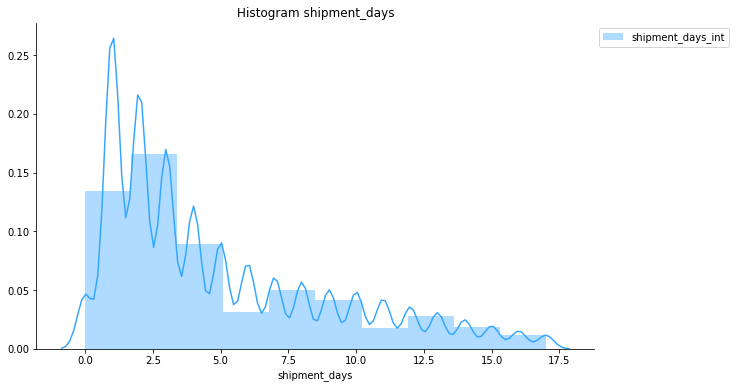

In [0]:
plt.figure(figsize=(10,6))
seaborn.distplot(dataset_clean['shipment_days'], color=BLUE, label='shipment_days_int',bins=10)
plt.title('Histogram shipment_days')
plt.legend(bbox_to_anchor=(1, 1), loc=2)
seaborn.despine()

Para reafirmar la falta de normalidad, se presenta el gráfico denominado *Q-Q plot*. Este gráfico representa en uno de sus ejes los valores reales de una variable de interés, y en un otro eje los valores teóricos de una distribución de probabilidad conocida con la cual son comparados. Si Los puntos que representan a las observaciones se posicionan aproximadamente sobre una línea de 45 grados, significa que la distribución de la variable de interés se distribuye como la distribución teórica considerada.

En este caso en particular se analiza el ajuste a una distribución normal de la variable *shipment_days*, cuyos parámetros están dado por la media (4.89) y la desviación estándar (4.14). Como se refleja en el siguiente gráfico, la distribución de la variable no se ajusta normal debido a que los puntos se alejan de la recta de 45 grados (representada de color rojo). 

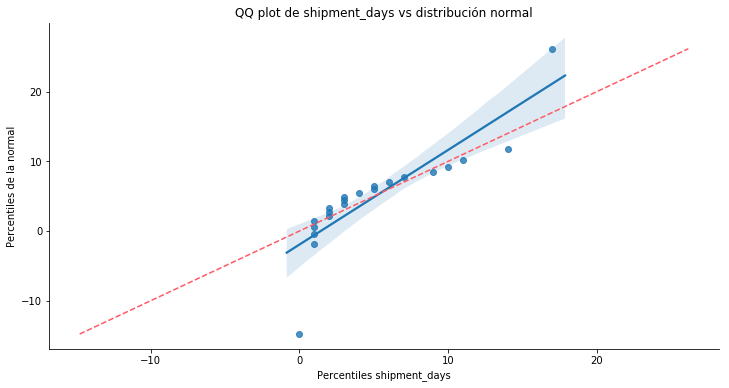

In [0]:
loc, scale = stats.norm.fit(dataset_clean['shipment_days'])
norm_dist = stats.norm(loc, scale)
percs = numpy.linspace(0,100,21)  # Creamos 20 puntos percentiles igualmente distribuidos entre 0 y 100.
qn_sample = numpy.percentile(dataset_clean['shipment_days'], percs)
qn_norm_dist = numpy.percentile(norm_dist.rvs(len(dataset_clean['shipment_days'])), percs)
plt.figure(figsize=(12,6))
seaborn.regplot(x=qn_sample, y=qn_norm_dist)
plt.xlabel('Percentiles shipment_days')
plt.ylabel('Percentiles de la normal')
plt.title('QQ plot de shipment_days vs distribución normal')
x = numpy.linspace(numpy.min((qn_sample.min(), qn_norm_dist.min())), numpy.max((qn_sample.max(),qn_norm_dist.max())))
plt.plot(x,x, color=RED, ls="--")

seaborn.despine()

El test de Kolmogorov–Smirnov es una prueba estadística empleada habitualmente para determinar el ajuste de una variable a una distribución de probablidad de referencia, por ejemplo la norma. La hipótesis nula de la prueba (la cual queremos testear) asume que la distribución se ajusta a la distribución teórica. La decisión de rechazar o no la hipótesis nula se toma analizando el *p value*, como es habitual en los test de hipótesis estadísticas.

En el caso particular de la variable *shipment days*, se emplea la prueba Kolmogorov–Smirnov para contrastar la hipótesis de que se ajuste a una distribución normal con parámetros dados po la media (4.89) y desviación estándar (4.14) de la muestra. El *p value* de la prueba es aproximadamente 0, por lo que se rechaza que *shipment days* tenga distribución normal.

In [0]:
data_plot = dataset_clean['shipment_days']
mean = data_plot.mean()
desv = data_plot.std()
stats.kstest(data_plot, 'norm', args=(mean,desv))

KstestResult(statistic=0.1860997881354025, pvalue=0.0)

Analizando nuevamente el histograma, la distribución de *shipment days* se asemeja a una distribución de probabilidad exponencial. El paŕametro que caracteriza a esta distribución se denomina $\lambda$ (*lambda*) y es estimado como la media de la variable.

A continuación se presenta el *Q-Q plot* para la variable *shipment days* correspondiente a una distribución exponencial con parámetro $\lambda = 4.89$. El ajuste es mucho mejor en relación a la normal, aunque hay un punto que se aleja de la recta de 45 grados. 

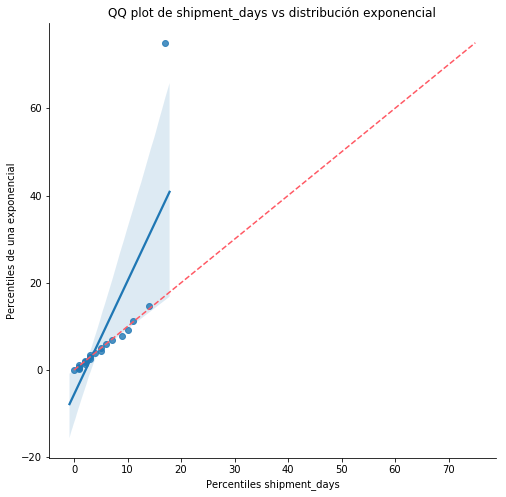

In [0]:
loc, scale = stats.expon.fit(dataset_clean['shipment_days'])
expon_dist = stats.expon(loc, scale)
percs = numpy.linspace(0,100,21)  # Creamos 20 puntos percentiles igualmente distribuidos entre 0 y 100.
qn_sample = numpy.percentile(dataset_clean['shipment_days'], percs)
qn_expon_dist = numpy.percentile(expon_dist.rvs(len(dataset_clean['shipment_days'])), percs)
plt.figure(figsize=(8,8))
seaborn.regplot(x=qn_sample, y=qn_expon_dist)
plt.xlabel('Percentiles shipment_days')
plt.ylabel('Percentiles de una exponencial')
plt.title('QQ plot de shipment_days vs distribución exponencial')
x = numpy.linspace(numpy.min((qn_sample.min(), qn_expon_dist.min())), numpy.max((qn_sample.max(),qn_expon_dist.max())))
plt.plot(x,x, color=RED, ls="--")
seaborn.despine()

## Distribución geográfica 
Las variables *sender zipcode* y *receiver_zipcode* son de naturaleza cualitativa, dado que hacen referencia a áreas geograficas desde donde se realizan o reciben los envíos.

A continuación se presenta un gráfico denominado *jointplot*, cual nos permite representar (de manera suavizada) la distribución conjunta de dos variables. Al analizar las variables *receiver_zipcode* y *sender_zipcode* mediante este gráfico vemos que las zonas de mayor concentración (partes más oscuras del gráfico) se encuentra entre los valores [0, 5.000] y [12.000, 150.000] de *sender_zipcode*, y 0-20.000 de *receiver_zipcode*. Esto refleja la fuerte concentración de los envíos y recepciones dentro de Sao Paulo, estado al que pertenecen los códigos postales inferiores a 20.000. También se observa concentración, aunque relativamente menor, entre los *receiver_zipcode* 30.000-40.000 correspondientes a Mina Gerais.



<Figure size 720x432 with 0 Axes>

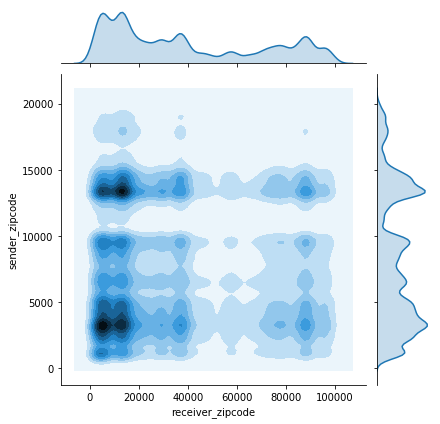

In [0]:
plt.figure(figsize=(10,6))
seaborn.jointplot(data=dataset_clean,
                  x='receiver_zipcode', y='sender_zipcode', kind='kde')

A continuación graficamos la distribución de *sender_zipcode*.

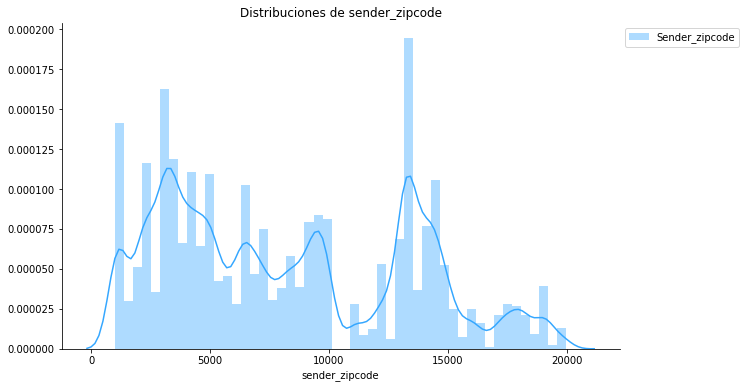

In [0]:
plt.figure(figsize=(10,6))
seaborn.distplot(dataset_clean['sender_zipcode'], color=BLUE, label='Sender_zipcode')
plt.title('Distribuciones de sender_zipcode')
plt.legend(bbox_to_anchor=(1, 1), loc=2)
seaborn.despine()

Los datos en *sender zipcode* se centran en 1300 aproximadamente.

A continuación graficamos la distribución de *receiver_zipcode*.

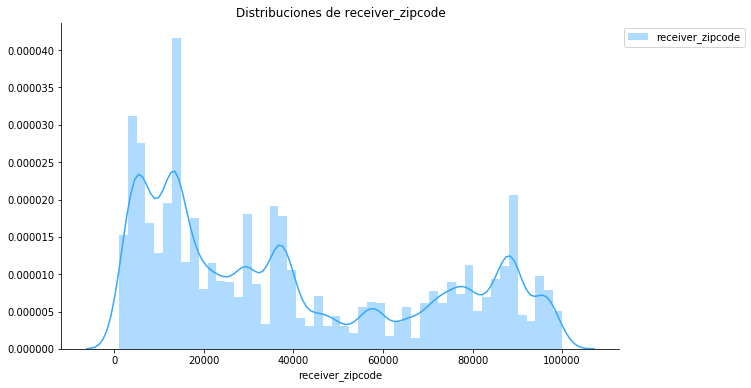

In [0]:
plt.figure(figsize=(10,6))
seaborn.distplot(dataset_clean['receiver_zipcode'], color=BLUE, label='receiver_zipcode')
plt.title('Distribuciones de receiver_zipcode')
plt.legend(bbox_to_anchor=(1, 1), loc=2)
seaborn.despine()

Los datos en *receiver zipcode* se centran en 1800 aproximadamente.


In [0]:
data_plot = dataset_clean['sender_zipcode']
mean = data_plot.mean()
desv = data_plot.std()
stats.kstest(data_plot, 'norm', args=(mean,desv))

KstestResult(statistic=0.111451275855868, pvalue=0.0)

De acuerdo a la prueba Kolmogorov–Smirnov podemos ver que la variable sender_zipcode no se ajusta a una normal.

In [0]:
data_plot = dataset_clean['receiver_zipcode']
mean = data_plot.mean()
desv = data_plot.std()
stats.kstest(data_plot, 'norm', args=(mean,desv))

KstestResult(statistic=0.1299292163781462, pvalue=0.0)

De acuerdo a la prueba Kolmogorov–Smirnov podemos ver que la variable receiver_zipcode no se ajusta a una normal.  

Cabe mencionar que tanto la media y desviación estándar en las pruebas de normalidad realizadas adquieren significado dado que son los parámetros de la distribución normal considerados  para realizar los test de hipótesis.

A continuación, se realizará el cáculo de algunas probabilidades basándonos en la distribución de frecuencias de las variables.

En la siguiente tabla se presentan los receptores de envíos. El 39,23% de los envíos son dirigidos a Sao Paulo y el 12,39% a Mina Gerais.

In [0]:
tab_receiver = pandas.crosstab(index = dataset_clean["receiver_state"],  # Make a crosstab
                              columns="count")      # Name the count column
tab_receiver['porcentaje_envio'] = (tab_receiver['count']/tab_receiver['count'].sum())

tab_receiver.sort_values(by=['porcentaje_envio'], ascending=False)

col_0,count,porcentaje_envio
receiver_state,,
SP,190101,0.392268
MG,60048,0.123907
RJ,41173,0.084959
RS,30472,0.062878
PR,28449,0.058704
SC,22336,0.046090
BA,20155,0.041589
GO,12872,0.026561
PE,11489,0.023707


In [0]:
areas, counts = numpy.unique(dataset_clean.receiver_state.values.astype(str),
                             return_counts=True)
total = counts.sum()
fdps = [x/float(total) for x in counts]
#[x for x in zip(areas, fdps)]
[x for x in zip(areas, fdps)][10]
# Cuál es la probabilidad de que el destinatario de un envío sea del estado de Minas Gerais (MG)?
probabilidad_mg = [x for x in zip(areas, fdps)][10][1]
probabilidad_mg

0.12390739135817753

In [0]:
# Probabilidad de que el envío sea mediante el servicio 1 dado que fue dirigido a Mina Gerais
dataset_clean[(dataset_clean.receiver_state == 'MG') & (dataset_clean.service == 1)].receiver_state.count()/dataset_clean[dataset_clean.receiver_state == 'MG'].receiver_state.count()

0.5250299760191847

La probabilidad de que un envío se realice por el método *super express* es de 2,12%.

In [0]:
areas_2, counts_2 = numpy.unique(dataset_clean.shipment_type.values.astype(str),
                             return_counts=True)
total_2 = counts_2.sum()
#Cuál es la probabilidad de que un envío sea realizado con el método super express
fdps_2 = [x/float(total_2) for x in counts_2]
[x for x in zip(areas_2, fdps_2)][2]

('super', 0.021165036523461682)

Finalmente, la probabilidad e que el envío sea destinado a Mina Gerais dado que fue enviado mediante el método super express es de 6.43%.

In [0]:
# Probabilidad de que el envío sea destinado a Mina Gerais dado que fue enviado mediante el método super express
(dataset_clean[(dataset_clean.receiver_state == 'MG') & (dataset_clean.shipment_type == 'super')].shipment_type.count()/dataset_clean[dataset_clean.shipment_type == 'super'].receiver_state.count()*100).round(2)

6.43

## Correlación entre variables
Si bien se comentó anteriormente que la variable *receiver_zipcode* es de tipo cualitativa, a efectos meramente exploratorios se analizará su correlación con la variable *shipment_days*. Mediante el coeficiente de correlación de *Spearman* se puede medir la asociación lineal entre estas variables. El signo de este coeficiente indica el sentido de la asociación, mientras que valores más cercanos a 1 en valor absoluto indican mayor intensidad en la relación.

En la siguiente tabla se observa que el coeficiente de correlación de Pearson entre *receiver_zipcode* y *shipment_days* es positiva.

In [0]:
corr_data = dataset_clean[['shipment_days','receiver_zipcode']]
corr_data.corr(method ='spearman')

,shipment_days,receiver_zipcode
shipment_days,1.000000,0.552391
receiver_zipcode,0.552391,1.000000



Entre las variables shipment_days y quantity no hay indicios de correlación lineal, ya que el coeficiente de correlación es cercano a 0.

In [0]:
corr_data = dataset_clean[['shipment_days','quantity']]
corr_data.corr(method ='spearman')

,shipment_days,quantity
shipment_days,1.000000,-0.001243
quantity,-0.001243,1.000000


In [0]:
corr_data = dataset_clean[['shipment_days','quantity']]
corr_data.corr(method ='pearson')

,shipment_days,quantity
shipment_days,1.000000,-0.001418
quantity,-0.001418,1.000000


In [0]:
corr_data = dataset_clean[['shipment_days','service','status']]
corr_data.corr(method ='spearman')

,shipment_days,service
shipment_days,1.000000,0.111559
service,0.111559,1.000000


* Shipment_days con service no estan correlacionadas 
* Y analizar Shipment_days con otras variables sólo tendría sentido con la distancia, pero no tenemos dicho dato. Con las demás variables por ejemplo fecha no tiene sentido analizar las correlaciones.

Con el objetivo de analizar la independencia entre las variables quantity y shipment_days, se reexpresó a esta última en intervalos. De esta manera se conformó una tabla de contingencia donde se observa la distribución de frecuencia conjunta entre las variables.

In [0]:
tab_cont = pandas.crosstab(pandas.cut(dataset_clean['shipment_days'], bins = [1, 3, 6, 9, 12, 15, 18], include_lowest=True), dataset_clean['quantity'])
tab_cont

quantity,1,2,3,4,5
shipment_days,,,,,
"(0.999, 3.0]",186345,31997,7305,4519,1158
"(3.0, 6.0]",79689,13816,3208,1802,480
"(6.0, 9.0]",47164,8007,1777,1118,288
"(9.0, 12.0]",36011,6038,1398,834,223
"(12.0, 15.0]",20989,3632,823,499,127
"(15.0, 18.0]",7636,1222,345,169,49


A partir de esta tabla es posible realizar el test de independencia Chi cuadrado, donde la hipótesis nula a probar es que las variables quantity y shipment_days son estadísticamente independientes. Con un p value de aproximadamente 0.07 (si bien no es muy concluyente), podemos decir que las variables son independientes: la probabilidad del tiempo que demore el envío no se ve condicionada por la cantidad de productos.

In [0]:
chi2, p, dots, expected = stats.chi2_contingency(tab_cont)
chi2, p

(30.09491594061473, 0.06833021098189274)

A continuación podemos observar un gráfico que muestra la información estadística ( la media y la presencia de outliers del número de días que tardan los envíos que se realizan a los diferentes estados de Brasil).

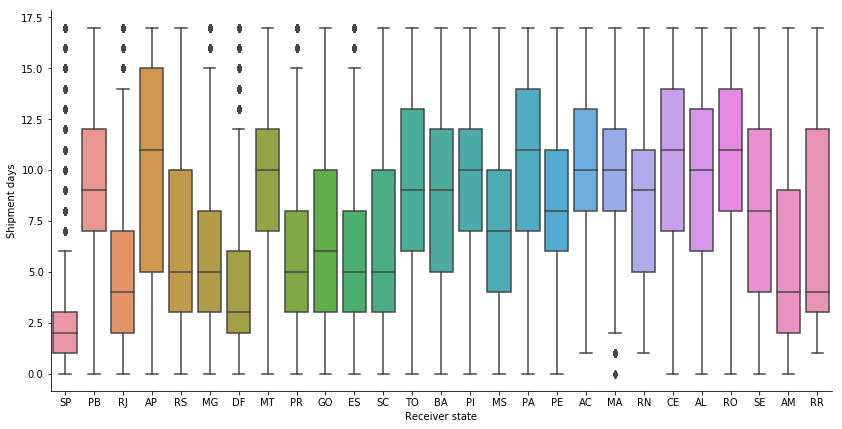

In [0]:
plt.figure(figsize=(14,7))
seaborn.boxplot(data=dataset_clean,
                y='shipment_days', x='receiver_state')
plt.ylabel('Shipment days')
plt.xlabel('Receiver state')
seaborn.despine()

In [0]:
descrip_state_st = dataset_clean.groupby('receiver_state')['shipment_days'].describe().round(2)
descrip_state_st['CV'] = (descrip_state_st['std']/descrip_state_st['mean']*100).round(2)
descrip_state_st.sort_values(by=['mean'])

,count,mean,std,min,25%,50%,75%,max,CV
receiver_state,,,,,,,,,
SP,190101.0,2.31,2.21,0.0,1.0,2.0,3.0,17.0,95.67
DF,10796.0,4.39,3.84,0.0,2.0,3.0,6.0,17.0,87.47
RJ,41173.0,5.10,3.94,0.0,2.0,4.0,7.0,17.0,77.25
PR,28449.0,5.45,3.59,0.0,3.0,5.0,8.0,17.0,65.87
MG,60048.0,5.49,3.60,0.0,3.0,5.0,8.0,17.0,65.57
ES,9889.0,5.89,3.67,0.0,3.0,5.0,8.0,17.0,62.31
AM,1155.0,6.32,4.85,0.0,2.0,4.0,9.0,17.0,76.74
RS,30472.0,6.57,4.43,0.0,3.0,5.0,10.0,17.0,67.43
SC,22336.0,6.60,4.45,0.0,3.0,5.0,10.0,17.0,67.42


El estado que en promedio tiene una mayor demora es RO. La distancia desde Rondonia hasta Sao Paulo es 2236 km. 
La de menor distancia es DF(distrito federal) que es 869km.

A continuación se presenta una tabla con la distribución de la entrega de envíos por hora del día para cada uno de los estados de Brasil. En todos los estados, los envíos están concentrados entre las 9 y 17 horas.

In [0]:
dataset_hora =pandas.crosstab(pandas.to_datetime(dataset_clean['date_visit']).dt.hour, dataset_clean['receiver_state'])
dataset_hora

receiver_state,AC,AL,AM,AP,BA,CE,DF,ES,GO,MA,MG,MS,MT,PA,PB,PE,PI,PR,RJ,RN,RO,RR,RS,SC,SE,SP,TO
date_visit,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0,1,0,0,4,3,2,9,2,3,13,3,1,7,0,5,3,61,36,1,0,0,84,39,0,67,0
1,0,0,0,0,5,0,2,2,6,0,2,1,5,0,0,6,0,130,26,3,0,0,7,19,0,30,5
2,0,0,0,0,4,1,36,3,0,0,4,2,2,0,0,4,0,178,3,0,0,0,4,19,0,24,0
3,0,3,0,0,1,0,10,9,1,2,4,0,1,0,2,2,0,53,7,0,0,0,9,5,7,32,2
4,0,5,0,1,7,13,13,5,0,5,37,0,0,0,11,8,0,74,17,1,0,0,3,2,5,26,0
5,0,9,0,0,55,18,9,47,3,22,75,1,1,15,33,43,17,39,82,23,0,0,9,20,24,233,0
6,2,19,5,0,130,42,28,58,60,34,256,44,45,22,82,121,19,59,191,42,3,0,97,92,40,1089,2
7,12,56,27,25,549,75,88,169,179,76,1017,165,360,104,92,304,100,349,365,70,37,0,659,570,58,2916,63
8,24,83,80,64,1082,110,250,407,485,90,2228,190,568,160,148,534,167,1002,928,101,137,5,1481,1333,95,5878,66


In [18]:
dataset_clean['hora'] = pandas.to_datetime(dataset_clean['date_visit']).dt.hour
dataset_clean
#df[columna].value_counts(normalize=True).plot(kind='bar')

C:\Users\cintia.chaves\AppData\Local\Continuum\anaconda3\envs\diplodatos\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,sender_state,sender_zipcode,receiver_state,receiver_zipcode,shipment_type,quantity,service,status,date_created,date_sent,date_visit,shipment_days,hora
0,SP,1039,SP,14500,standard,1,1,done,2019-03-10 00:00:00,2019-03-11 14:34:00,2019-03-18 09:52:00,5.0,9
1,SP,3004,PB,58670,standard,1,1,done,2019-03-08 00:00:00,2019-03-09 10:48:00,2019-03-18 15:16:00,5.0,15
2,SP,3262,RJ,22723,standard,1,2,done,2019-02-21 00:00:00,2019-02-23 02:02:16,2019-03-01 21:27:00,4.0,21
3,SP,12237,SP,18682,standard,1,2,done,2019-02-25 00:00:00,2019-02-28 03:05:36,2019-03-07 15:01:00,2.0,15
4,SP,9350,AP,68908,standard,1,1,done,2019-02-15 00:00:00,2019-02-15 11:28:00,2019-03-11 13:18:00,13.0,13
5,SP,3806,RS,91060,express,1,9,done,2019-03-19 00:00:00,2019-03-21 01:33:32,2019-03-25 08:29:00,2.0,8
6,SP,17280,SP,7776,express,1,0,done,2019-02-26 00:00:00,2019-02-27 11:44:00,2019-03-01 14:27:00,2.0,14
7,SP,4132,MG,35910,standard,2,1,done,2019-02-20 00:00:00,2019-02-22 16:34:00,2019-03-01 09:22:00,5.0,9
8,SP,9112,RJ,21755,standard,4,2,done,2019-02-10 00:00:00,2019-02-27 01:26:44,2019-03-11 16:05:00,5.0,16
9,SP,14401,MG,38703,express,1,0,done,2019-03-19 00:00:00,2019-03-19 17:31:00,2019-03-21 13:17:00,2.0,13


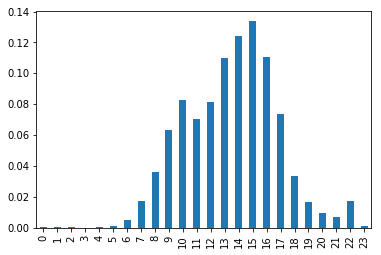

In [20]:
dataset_clean['hora'].value_counts(normalize=True,sort=False).plot(kind='bar')

# Conclusión

Este informe constituye una primera aproximación para analizar el tiempo que transcurre entre el momento en que el cliente realiza un pedido al sitio de mercado libre en Brasil, y el momento en que se le es entregado.
Un aspecto a trabajar a seguir trabajando sería en relación a determinar el ajuste de la variable shipment days. Otro modelo que se podría considerar dada la característica de la distribución es la Gamma.
Y otra variable que podríamos agregar en los datos, sería la distancia entre las zonas geográficas de envío y recepción (por su importancia en los tiempos de envío).